In [7]:
%pip install tf_keras_vis tflite-support-nightly

Note: you may need to restart the kernel to use updated packages.Collecting tf_keras_vis
  Using cached tf_keras_vis-0.8.7-py3-none-any.whl.metadata (10 kB)



ERROR: Ignored the following versions that require a different python version: 0.2.0 Requires-Python >=3.5, <3.8; 0.2.1 Requires-Python >=3.5, <3.8; 0.2.3 Requires-Python >=3.5, <3.8; 0.2.4 Requires-Python >=3.5, <=3.8; 0.2.5 Requires-Python >=3.5, <3.9; 0.3.1 Requires-Python >=3.5, <3.9; 0.3.2 Requires-Python >=3.5, <3.9; 0.3.3 Requires-Python >=3.5, <3.9; 0.4.0 Requires-Python >=3.5, <3.9; 0.5.0 Requires-Python >=3.5, <3.9; 0.5.2 Requires-Python >=3.5, <3.9; 0.5.3 Requires-Python >=3.5, <3.9; 0.5.4 Requires-Python >=3.5, <3.9; 0.5.5 Requires-Python >=3.6, <3.9
ERROR: Could not find a version that satisfies the requirement tflite-support-nightly (from versions: none)
ERROR: No matching distribution found for tflite-support-nightly


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [9]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [10]:
train_df = create_dataframe_from_directories("dataset_train")
test_df = create_dataframe_from_directories("dataset_test")

In [11]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['Slice Pumpkin Pie', 'Slice Strawberry Pie'], dtype=object)

**TODO**: Display some images of your dataset

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

# Preprocessing steps

In [13]:
import PIL
from keras.src.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import (
    Resizing, Rescaling,
)

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
    
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

**TODO**: plot examples of preprocessed and augmented images

## Define model

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        # TODO: ...
        Dense(2048, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(len(LABEL_NAMES), activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in base_model.layers:
        layer.trainable = False
    
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [16]:
get_model().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 6,981,698 (26.63 MB)

 Trainable params: 4,723,714 (18.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [18]:
from pandas.core.interchange import dataframe
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    try:

        train_images = open_images(total_train_paths[train_index])
        train_labels = total_train_labels[train_index]

        val_images = open_images(total_train_paths[val_index])
        val_labels = total_train_labels[val_index]
    finally:
        print("dommage")

    model = get_model() # We reinitialize the model

    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

dommage
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - acc: 0.3808 - loss: 2.5907 - val_acc: 0.5882 - val_loss: 14.2115
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - acc: 0.6739 - loss: 12.1873 - val_acc: 1.0000 - val_loss: 0.0413
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - acc: 1.0000 - loss: 0.0435 - val_acc: 1.0000 - val_loss: 0.0139
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 858ms/step - acc: 0.9808 - loss: 0.0448 - val_acc: 1.0000 - val_loss: 0.0070
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - acc: 1.0000 - loss: 0.0073 - val_acc: 1.0000 - val_loss: 0.0052
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - acc: 1.0000 - loss: 0.0116 - val_acc: 1.0000 - val_loss: 0.0033
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 1.0000 - loss: 0.0054 - val_acc: 1.0000 - val_loss: 0.0031
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 1.0000 - loss: 0.0035 - val_acc: 1.0000 - val_loss: 0.0192
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - acc: 1.0000 - loss: 0

# Results

**TODO**: plot the results from your crossvalidation

In [19]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)

    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


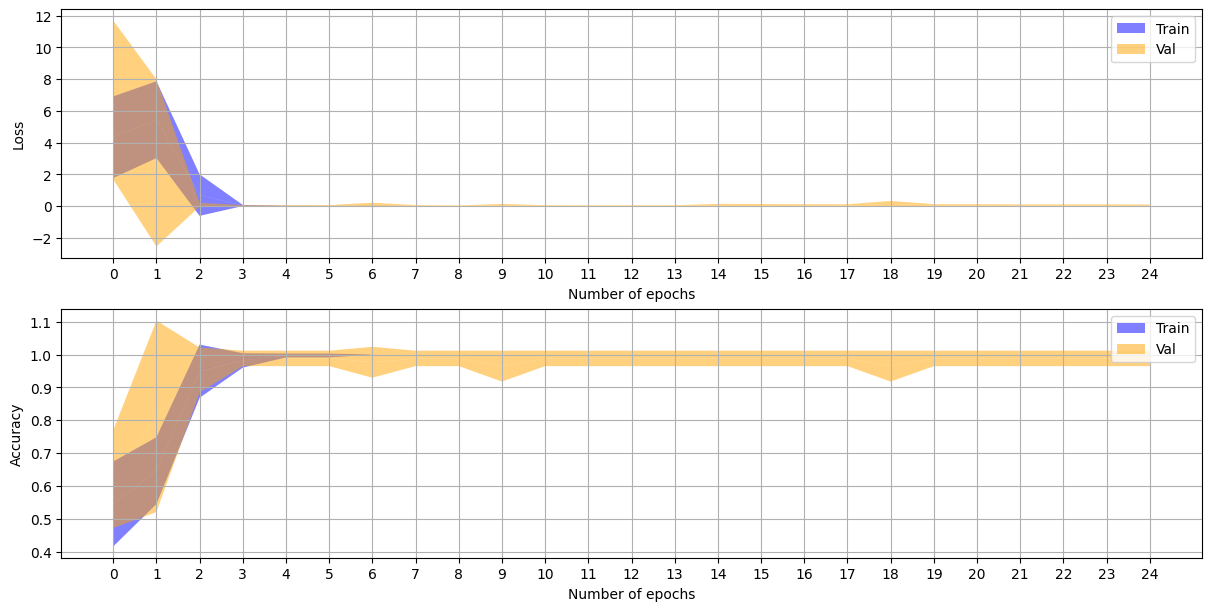

In [20]:

import matplotlib.pyplot as plt



fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [21]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - acc: 0.4883 - loss: 5.3187
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - acc: 0.4410 - loss: 2.4917
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 989ms/step - acc: 1.0000 - loss: 0.0109
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.9823 - loss: 0.0243
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - acc: 1.0000 - loss: 0.0054
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - acc: 1.0000 - loss: 0.0036
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - acc: 0.9901 - loss: 0.0140
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - acc: 1.0000 - loss: 0.0023
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 1.0000 - loss: 0.0029
Epoch 10/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 1.0000 - loss: 0.0024
Epoch 11/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - acc: 1.0000 - loss: 0.0027
Epoch 12/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 1.0000 - loss: 0.0013
Epoch 13/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 1.0000 - loss: 0.

In [22]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

58931

In [23]:
import sklearn.metrics as me

test_images = open_images(test_paths)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


NameError: name 'QUERIES' is not defined

In [ ]:
QUERIES = ["Slice Apple pie",
           "Slice Strawberry Pie",
           "Slice Apricots Pie",
           "Slice Orange Pie",
           "Slice Pumpkin Pie",
           "Slice Pineapple Pie",
           "Slice Cherry Pie",
           "Slice Carrot Pie",
           "Slice Banana Pie",
           "Slice Chocolate Pie"
           ]

confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


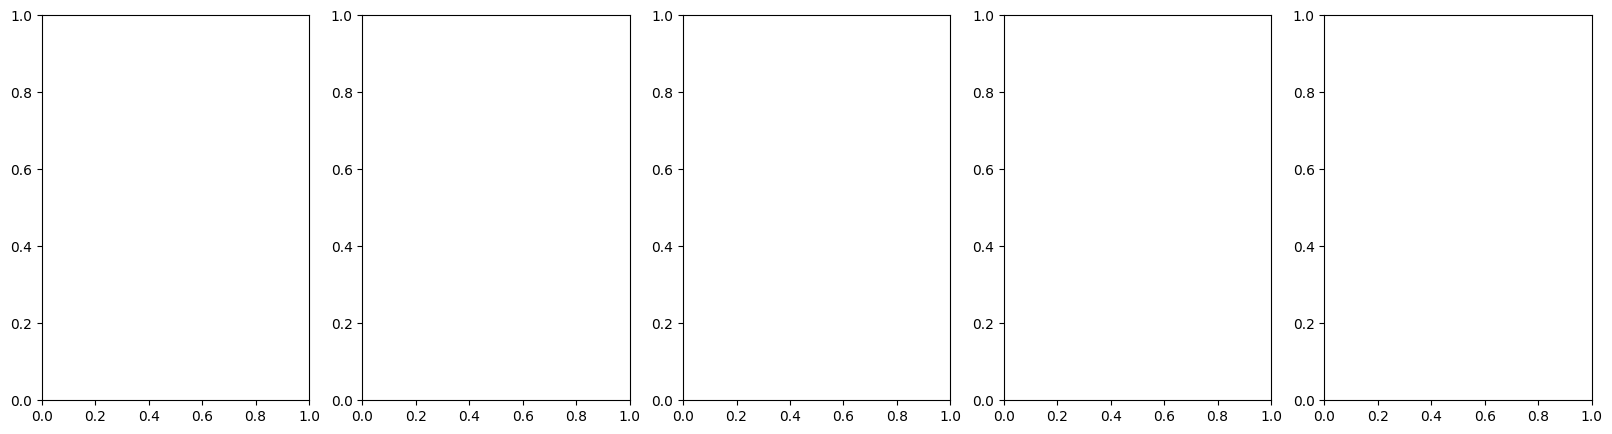

In [25]:
import matplotlib.pyplot as plt

# Get the predictions for the test set
preds = model.predict(test_images)

# Convert predictions from probabilities to class labels
pred_labels = np.argmax(preds, axis=1)

# Find the indices of the misclassified images
misclassified_indices = np.where(pred_labels != test_labels)[0]

# Select the first few misclassified images
misclassified_images = test_images[misclassified_indices[:5]]
misclassified_labels = pred_labels[misclassified_indices[:5]]
true_labels = test_labels[misclassified_indices[:5]]

# Plot the misclassified images along with their predicted and actual labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (img, pred_label, true_label) in enumerate(zip(misclassified_images, misclassified_labels, true_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {LABEL_NAMES[pred_label]}, Actual: {LABEL_NAMES[true_label]}")
    axes[i].axis('off')
plt.show()

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it